# Języki programowania Python i R
# Projekt - 'UCL statistics - modele klasyfikacji wyników drużyn w Lidze Mistrzów w sezonach 2000/2001 - 2018/2019'


### Oskar Kwidziński
### Politechnika Gdańska
### Wydział Fizyki Technicznej i Matematyki Stosowanej

# 1. Wstęp

#### Motywacją projektu jest przewidzenie wyniku drużyny w danym sezonie rozgrywek piłkarskiej Ligi Mistrzów. Model ma za zadanie znaleźć schemat pozwalający określić jakie warunki dana drużyna musi spełnić by zostać mistrzem rozgrywek. Oczywistym jest, że analiza która została dokonana, została przeprowadzona po czasie i nie jest możliwe by wpłynąć na wyniki drużyny po fakcie. Jednocześnie, przeprowadzona analiza może posłużyć jako zbiór wskazówek dla startujących w Lidze Mistrzów drużyn. Dane zostały pobrane ze strony https://www.kaggle.com/bakar31/ucl-statistics.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn #uczenie maszynowe
import sklearn.linear_model
import scipy as sc
import sklearn.preprocessing
import sklearn.model_selection
import sklearn.neighbors
import sklearn.metrics
import sklearn.tree

# 2. Podstawowe informacje o danych

#### Zbiór danych zawiera 720 obserwacji opisanych 11 atrybutami. Każdy z rekordów definiuje wyniki drużyny w danym sezonie Ligi Mistrzów od momentu jej założenia - sezon 1992/1993, aż do sezonu 2020/2021. Zbiór danych zawiera występy wszystkich drużyn, które w tych latach przystąpiły do rozgrywek. W pierwszym sezonie liczba drużyn wynosiła 8, by w kolejnych latach zwiększać się i począwszy od sezonu 1999/2000 ustabilizować się na poziomie 32 drużyn na sezon. 
#### Kolejne zmienne opisowe w zbiorze danych definiują występ drużyny w danej kampanii i są to:
#### * year - sezon rozgrywek; zbiór danych definiuje sezon rozgrywek jako rok w którym zakończyły się rozgrywki, 
#### * team - nazwa drużyny; zawiera 146 unikalnych wpisów z drużyną Real Madryt występującą najczęściej (24 razy),
#### * match_played - liczba meczy rozegranych; minimalna ilość 6 dla drużyn które odpadły po pierwszym etapie rozgrywek (fazie grupowej, w której cztery drużyny rozgrywają mecze każdy z każdym w formacie mecz-wyjazd), maksymalna ilość 13 dla drużyn które dotarły do finału począwszy od sezonu 1999/2000,
#### * wins - liczba meczy wygranych,
#### * draws - liczba meczy zremisowanych,
#### * losts - liczba meczy przegranych,
#### * goals_scored - liczba bramek strzelonych,
#### * goals_conceded - liczba bramek straconych,
#### * gd - różnica bramek; obliczana na podstawie różnicy bramek strzelonych i bramek straconych,
#### * group_point - liość punktów zdobytych w fazie grupowej; maksymalna ilość 18 punktów odpowiadająca sześciu zwycięstwom w meczach grupowych, minimalna ilość 0 punktów odpowiadająca sześciu porażkom w fazie grupowej, w fazie grupowej przyznawane są 3 punkty za zwycięstwo, 1 punkt za remis i 0 punktów za porażkę,
#### * champions - zmienna binarna (1 - zwycięstwo, 0 - brak zwycięstwa w danej edycji Ligi Mistrzów); w każdym sezonie wyłoniono jednego zwycięzce co daje 28 zwycięzców rozgrywek.
#### Z racji na motywacje i cele prowadzonych badań atrybuty 'year' oraz 'team' nie będą podlegały analizie. Większość atrybutów posiada w przybliżeniu rozkład normalny. Z wyjątkiem atrybutu 'champions' wszystkie zmienne są zmiennymi ilościowymi o rozkładzie dyskretnym.  Zmienna 'Champions' będzie stanowiła zmienną celu w zadaniu klasyfikacyjnym; zaś zmienna 'gd' będzie stanowiła zmienną celu w zadaniu modelowania regresyjnego. W przypadku tej pierwszej trzeba uwzględnić fakt, że zdecydowaną większość rekordów stanowią wyniki drużyn którym nie udało się wygrać rozgrywek. Z tego powodu w zadaniu klasyfikacyjnym trzeba będzie zwrócić uwagę by nie wpaść w paradoks wysokiej skuteczność na podstawie dominującej klasy.

In [2]:
stats = pd.read_csv("uclstats ds.csv", encoding='cp1250')

In [3]:
stats.iloc[:, 0:11].describe(include='all').round(1).T.iloc[:, 1:]

,unique,top,freq,mean,std,min,25%,50%,75%,max
year,NaN,NaN,NaN,2008.7,7.4,1993,2004,2009,2015,2020
team,147,Real Madrid,24,NaN,NaN,NaN,NaN,NaN,NaN,NaN
match_played,NaN,NaN,NaN,7.7,2.1,6,6,6,8,13
wins,NaN,NaN,NaN,2.9,2.3,0,1,2,4,11
draws,NaN,NaN,NaN,1.8,1.3,0,1,2,3,7
losts,NaN,NaN,NaN,2.9,1.2,0,2,3,4,6
goals_scored,NaN,NaN,NaN,10.5,7,0,5,9,14,43
goals_conceded,NaN,NaN,NaN,10.5,3.7,2,8,10,13,24
gd,NaN,NaN,NaN,0.1,7.6,-22,-5,0,5,35
group_point,NaN,NaN,NaN,8.1,4.2,-8,5,8,11,18


In [4]:
stats.team = stats.team.astype("category")

In [5]:
stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 720 entries, 0 to 719
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   year            720 non-null    int64   
 1   team            720 non-null    category
 2   match_played    720 non-null    int64   
 3   wins            720 non-null    int64   
 4   draws           720 non-null    int64   
 5   losts           720 non-null    int64   
 6   goals_scored    720 non-null    int64   
 7   goals_conceded  720 non-null    int64   
 8   gd              720 non-null    int64   
 9   group_point     720 non-null    int64   
 10  champions       720 non-null    int64   
dtypes: category(1), int64(10)
memory usage: 63.9 KB


In [6]:
stats.head(10)

,year,team,match_played,wins,draws,losts,goals_scored,goals_conceded,gd,group_point,champions
0,1993,Marseille,7,4,3,0,14,4,10,9,1
1,1993,Milan,7,6,0,1,11,2,9,12,0
2,1993,Rangers,6,2,4,0,7,5,2,8,0
3,1993,Club Brugge,6,2,1,3,5,8,-3,5,0
4,1993,CSKA Moscow,6,0,2,4,2,11,-9,2,0
5,1993,IFK Göteborg,6,3,0,3,7,8,-1,6,0
6,1993,Porto,6,2,1,3,5,5,0,5,0
7,1993,PSV Eindhoven,6,0,1,5,4,13,-9,1,0
8,1994,Spartak Moscow,6,1,3,2,6,12,-6,5,0
9,1994,Galatasaray,6,0,2,4,1,10,-9,2,0


In [7]:
stats.tail(15)

,year,team,match_played,wins,draws,losts,goals_scored,goals_conceded,gd,group_point,champions
705,2020,Napoli,8,3,4,1,13,8,5,12,0
706,2020,Red Bull Salzburg,6,2,1,3,16,13,3,7,0
707,2020,Genk,6,0,1,5,5,20,-15,1,0
708,2020,Barcelona,9,5,3,1,15,14,1,14,0
709,2020,Borussia Dortmund,8,4,1,3,10,11,-1,10,0
710,2020,Inter Milan,6,2,1,3,10,9,1,7,0
711,2020,Slavia Prague,6,0,2,4,4,10,-6,2,0
712,2020,RB Leipzig,10,6,2,2,16,12,4,11,0
713,2020,Lyon,10,4,2,4,14,14,0,8,0
714,2020,Benfica,6,2,1,3,10,11,-1,7,0


In [8]:
sns.pairplot(stats)
plt.show()

# 3. Klasyfikacja wyniku drużyny w rozgrywkach na podstawie statystyk drużyny w sezonie

## 3a) Przygotowanie danych

#### Stworzono ramkę danych stats_cls w celu analizy działania klasyfikatorów. Dodatkowo wykluczono wszystkie rekordy, które mogłyby wypaczać wynik działania modelu - pozostawiono jedynie wyniki odnotowane po roku 2000 (tj. po reformie rozgrywek i wprowadzenia jednolitego schematu rozgrywek z 32 drużynami) i bez sezonu 2019/2020 z racji na modyfikację systemu rozgrywek z racji na epidemię COVID-19. Proces ten jest niezbędny by uzyskać wyniki spójne, z racji na fakt rozgrywania mniejszej ilości spotkań w wymieionych sezonach.

In [9]:
stats_cls = stats
stats_cls = stats_cls[stats.year > 2000]
stats_cls = stats_cls[stats.year < 2020]
stats_cls.reset_index(inplace=True)
stats_cls = stats_cls.iloc[:, 3:]
stats_cls = stats_cls.iloc[:, [1,6,7,8] ]

/srv/conda/envs/notebook/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


#### Po wstępnej analizie danych udało się ustalić od których atrybutów zmienna 'champions' jest najbardziej zależna i które są niezbędne do wykonania dobrej predykcji. Dlatego do dalszej analizy pozostawiono jedynie zmienne: 'wins', 'gd', 'group_point'.

#### Znaleziono współczynniki korelacji Pearsona i Spearmana w oryginalnym zbiorze danych 'stats'. Na bazie wyznaczonych współczynników korelacji stwierdzono że zmienna 'champions' jest zależna od zmiennej 'wins' (przynajmniej w przypadku współczynnika Persona). Zmienna 'wins' silnie zależy od zmiennych 'group_point', 'gd' i 'match_played' oraz słabiej od 'losts' i 'champions'. 

In [10]:
corr_P = stats_cls.corr("pearson")
corr_P_tri = corr_P.where(np.triu(np.ones(corr_P.shape, dtype=np.bool), k=1)).stack().sort_values()
corr_P_tri[abs(corr_P_tri)>0.3]

gd    champions      0.357358
wins  champions      0.408297
gd    group_point    0.838050
wins  gd             0.864889
      group_point    0.867414
dtype: float64

In [11]:
corr_S = stats_cls.corr("spearman")
corr_S_tri = corr_S.where(np.triu(np.ones(corr_S.shape, dtype=np.bool), k=1)).stack().sort_values() # sortuje korelacje
corr_S_tri[abs(corr_S_tri)>0.3]

wins  gd             0.869536
gd    group_point    0.880825
wins  group_point    0.935089
dtype: float64

In [12]:
stats_cls

,wins,gd,group_point,champions
0,5,11,12,0
1,3,5,12,0
2,2,-9,6,0
3,0,-6,2,0
4,4,2,10,0
...,...,...,...,...
555,2,-1,7,0
556,5,5,12,0
557,4,-1,10,0
558,2,0,8,0


#### Sprawdzono dystrybucję zmiennej celu (champions)

In [13]:
ile = stats_cls["champions"].value_counts()
ile.iloc[np.argsort(ile.index)]

0    541
1     19
Name: champions, dtype: int64

In [14]:
stats_cls.head(10)

,wins,gd,group_point,champions
0,5,11,12,0
1,3,5,12,0
2,2,-9,6,0
3,0,-6,2,0
4,4,2,10,0
5,4,-1,10,0
6,1,-1,7,0
7,1,-2,5,0
8,7,9,13,1
9,3,-2,8,0


#### Stworzono zmienne definiujące zmianne opisowe (X_cls) i zmienną celu (y_cls)

In [15]:
X_cls = stats_cls.iloc[:, :-1] # zmienne opisowe
y_cls = stats_cls.iloc[:, -1] # zmienna celu

In [16]:
X_cls

,wins,gd,group_point
0,5,11,12
1,3,5,12
2,2,-9,6
3,0,-6,2
4,4,2,10
...,...,...,...
555,2,-1,7
556,5,5,12
557,4,-1,10
558,2,0,8


In [17]:
y_cls

0      0
1      0
2      0
3      0
4      0
      ..
555    0
556    0
557    0
558    0
559    0
Name: champions, Length: 560, dtype: int64

#### Podzielono zbiór na część uczącą i testową - zmienne opisowe (X_cls_ucz, X_cls_test) oraz zmienne celu (y_cls_ucz, y_cls_test) w proporcji 80:20, przez co stworzono zbiory danych o długościach odpowiednio 576 i 144.

In [18]:
idx_ucz, idx_test = sklearn.model_selection.train_test_split(np.arange(X_cls.shape[0]), test_size=0.2, random_state=1111)
X_cls_ucz, X_cls_test = X_cls.iloc[idx_ucz, :], X_cls.iloc[idx_test, :]
y_cls_ucz, y_cls_test = y_cls[idx_ucz], y_cls[idx_test]

In [19]:
len(X_cls_ucz)

448

In [20]:
len(X_cls_test)

112

In [21]:
len(y_cls_ucz)

448

In [22]:
len(y_cls_test)

112

#### Otrzymano dystrybucję zmiennej celu pomiędzy dwa zbiory o zbliżonej charakterystyce (ok. 3,3% zwycięzców w zbiorze y_cls_ucz i ok. 3,6% w zbiorze y_cls_test)

In [23]:
y_cls_ucz.value_counts()

0    435
1     13
Name: champions, dtype: int64

In [24]:
y_cls_test.value_counts()

0    106
1      6
Name: champions, dtype: int64

## 3b) Tworzenie modeli klasyfikacji

#### Głównym założeniem modelu jest sklasyfikowanie rekordów w taki sposób, by jak najlepiej był w stanie zidentyfikować rzeczywistych zwycięzów rozgrywek w obrębie zebranych danych. Dopuszcza się pomyłki w obrębie rekordów, które faktycznie odpowiadają wartościom 'champs' = 0. Celem modelu jest podanie odpowiedzi na pytanie jaki minimalnie zestaw warunków musi spełnić drużyna by zostać mistrzem, a nie dokładne przewidzenie sukscesu każdej z drużyn. To założenie zostało poczynione z racji na dysproporcję w dystrybucji zmiennej 'champs' . 

#### Stworzono funkcję pozwalającą dokonać ewaluacji i porównania modeli

In [25]:
def fit_classifier(alg, X_ucz, X_test, y_ucz, y_test):
    """
    Metoda trenująca wybrany model alg na zbiorze uczącym (X_ucz, y_ucz),
    dokonująca predykcji na zbioerze testowym (X_test, y_test) i
    walidująca go poprzez cztery wybrane metryki: accuracy, precision, recall i F1.
    
    Parameters:
        alg: obiekt reprezentujący wybrany algorytm, np. sklearn.neighbors.classification.KNeighborsClassifier
            algorytm użyty do klasyfikacji
        X_ucz: pandas.core.frame.DataFrame
            zbiór treningowy - predyktory
        X_test: pandas.core.frame.DataFrame
            zbiór testowy - predyktory
        y_ucz: pandas.core.series.Series
            zbiór treningowy - zmienna celu
        y_test: pandas.core.series.Series
            zbiór testowy - zmienna celu
    
    Returns:
        dict: słownik zawierający klucze ACC, P, R i F1,
            dla których wyznaczono wartości walidujące model, takie jak: accuracy, precision, recall i F1.
    """
      
    alg.fit(X_ucz, y_ucz)
    y_pred_ucz = alg.predict(X_ucz)
    y_pred = alg.predict(X_test)
    return {
        "ACC_ucz": sklearn.metrics.accuracy_score(y_pred_ucz, y_ucz),
        "ACC_test": sklearn.metrics.accuracy_score(y_pred, y_test),
        "P_ucz":   sklearn.metrics.precision_score(y_pred_ucz, y_ucz),
        "P_test":   sklearn.metrics.precision_score(y_pred, y_test),
        "R_ucz":   sklearn.metrics.recall_score(y_pred_ucz, y_ucz),
        "R_test":   sklearn.metrics.recall_score(y_pred, y_test),
        "F1_ucz":  sklearn.metrics.f1_score(y_pred_ucz, y_ucz),
        "F1_test":  sklearn.metrics.f1_score(y_pred, y_test),
        "Confusion_Matrix_ucz": sklearn.metrics.confusion_matrix(y_ucz, y_pred_ucz),
        "Confusion_Matrix_test": sklearn.metrics.confusion_matrix(y_test, y_pred)
    }


#### Zaproponowano klasyfikator k-najbliższych sąsiadów

In [26]:
knn = sklearn.neighbors.KNeighborsClassifier(n_neighbors=1)
knn.fit(X_cls_ucz, y_cls_ucz)
y_pred_knn = knn.predict(X_cls_test)

In [27]:
params = ["knn"]
res = [fit_classifier(knn, X_cls_ucz, X_cls_test, y_cls_ucz, y_cls_test)]
df_result = pd.DataFrame(res, index=params)

In [28]:
df_result

,ACC_ucz,ACC_test,P_ucz,P_test,R_ucz,R_test,F1_ucz,F1_test,Confusion_Matrix_ucz,Confusion_Matrix_test
knn,0.997768,0.928571,1.0,0.5,0.928571,0.375,0.962963,0.428571,"[[434, 1], [0, 13]]","[[101, 5], [3, 3]]"


#### Zaproponowano klasyfikator k-najbliższych sąsiadów po wystandaryzowaniu

In [29]:
m = X_cls.mean()
s = X_cls.std()
params.append("knn_std")
res.append(fit_classifier(sklearn.neighbors.KNeighborsClassifier(), (X_cls_ucz-m)/s, (X_cls_test-m)/s, y_cls_ucz, y_cls_test))
df_result = (pd.DataFrame(res, index=params))


In [30]:
df_result

,ACC_ucz,ACC_test,P_ucz,P_test,R_ucz,R_test,F1_ucz,F1_test,Confusion_Matrix_ucz,Confusion_Matrix_test
knn,0.997768,0.928571,1.000000,0.5,0.928571,0.375,0.962963,0.428571,"[[434, 1], [0, 13]]","[[101, 5], [3, 3]]"
knn_std,0.977679,0.955357,0.307692,0.5,0.800000,0.600,0.444444,0.545455,"[[434, 1], [9, 4]]","[[104, 2], [3, 3]]"


#### Zaproponowano klasyfikator k-najbliższych sąsiadów bez rekordów odstających

In [31]:
z_scores = sc.stats.zscore(stats_cls.iloc[:, :-1])
abs_z_scores = np.abs(z_scores)
filtered_z_scores = (abs_z_scores < 3).all(axis=1)
stats_cls_wout = stats_cls[filtered_z_scores]
stats_cls_wout.reset_index(inplace=True)
stats_cls_wout.champions.value_counts()


0    537
1     17
Name: champions, dtype: int64

In [32]:
X_cls_wout = stats_cls_wout.iloc[:, :-1] # predyktory - wszystkie kolumny oprocz ostatniej 
y_cls_wout = stats_cls_wout.iloc[:, -1] # zmienna objasniajaca - tylko ostatnia kolumna

In [33]:
idx_ucz, idx_test = sklearn.model_selection.train_test_split(np.arange(X_cls_wout.shape[0]), test_size=0.2, random_state=12345)
X_cls_wout_ucz, X_cls_wout_test = X_cls_wout.iloc[idx_ucz, :], X_cls_wout.iloc[idx_test, :]
y_cls_wout_ucz, y_cls_wout_test = y_cls_wout[idx_ucz], y_cls_wout[idx_test]

In [34]:
params.append("knn_wout")
res.append(fit_classifier(sklearn.neighbors.KNeighborsClassifier(), X_cls_wout_ucz, X_cls_wout_test, y_cls_wout_ucz, y_cls_wout_test))
df_result = (pd.DataFrame(res, index=params))

/srv/conda/envs/notebook/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/srv/conda/envs/notebook/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [35]:
df_result

,ACC_ucz,ACC_test,P_ucz,P_test,R_ucz,R_test,F1_ucz,F1_test,Confusion_Matrix_ucz,Confusion_Matrix_test
knn,0.997768,0.928571,1.000000,0.5,0.928571,0.375,0.962963,0.428571,"[[434, 1], [0, 13]]","[[101, 5], [3, 3]]"
knn_std,0.977679,0.955357,0.307692,0.5,0.800000,0.600,0.444444,0.545455,"[[434, 1], [9, 4]]","[[104, 2], [3, 3]]"
knn_wout,0.963883,0.990991,0.000000,0.0,0.000000,0.000,0.000000,0.000000,"[[427, 0], [16, 0]]","[[110, 0], [1, 0]]"


#### Zaproponowano klasyfikator drzew decyzyjnych 

In [36]:
tree = sklearn.tree.DecisionTreeClassifier(max_depth=3)
tree.fit(X_cls_ucz, y_cls_ucz)
params.append("dt")
res.append(fit_classifier(sklearn.tree.DecisionTreeClassifier(), X_cls_ucz, X_cls_test, y_cls_ucz, y_cls_test)) 
df_result = (pd.DataFrame(res, index=params))

In [37]:
df_result

,ACC_ucz,ACC_test,P_ucz,P_test,R_ucz,R_test,F1_ucz,F1_test,Confusion_Matrix_ucz,Confusion_Matrix_test
knn,0.997768,0.928571,1.000000,0.500000,0.928571,0.375000,0.962963,0.428571,"[[434, 1], [0, 13]]","[[101, 5], [3, 3]]"
knn_std,0.977679,0.955357,0.307692,0.500000,0.800000,0.600000,0.444444,0.545455,"[[434, 1], [9, 4]]","[[104, 2], [3, 3]]"
knn_wout,0.963883,0.990991,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,"[[427, 0], [16, 0]]","[[110, 0], [1, 0]]"
dt,0.997768,0.964286,0.923077,0.666667,1.000000,0.666667,0.960000,0.666667,"[[435, 0], [1, 12]]","[[104, 2], [2, 4]]"


#### Zaproponowano klasyfikator drzew decyzyjnych po standaryzacji

In [38]:
params.append("dt_std")
res.append(fit_classifier(sklearn.tree.DecisionTreeClassifier(max_depth=3), (X_cls_ucz-m)/s, (X_cls_test-m)/s, y_cls_ucz, y_cls_test)) 
df_result = (pd.DataFrame(res, index=params))

In [39]:
df_result

,ACC_ucz,ACC_test,P_ucz,P_test,R_ucz,R_test,F1_ucz,F1_test,Confusion_Matrix_ucz,Confusion_Matrix_test
knn,0.997768,0.928571,1.000000,0.500000,0.928571,0.375000,0.962963,0.428571,"[[434, 1], [0, 13]]","[[101, 5], [3, 3]]"
knn_std,0.977679,0.955357,0.307692,0.500000,0.800000,0.600000,0.444444,0.545455,"[[434, 1], [9, 4]]","[[104, 2], [3, 3]]"
knn_wout,0.963883,0.990991,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,"[[427, 0], [16, 0]]","[[110, 0], [1, 0]]"
dt,0.997768,0.964286,0.923077,0.666667,1.000000,0.666667,0.960000,0.666667,"[[435, 0], [1, 12]]","[[104, 2], [2, 4]]"
dt_std,0.982143,0.964286,0.769231,0.666667,0.666667,0.666667,0.714286,0.666667,"[[430, 5], [3, 10]]","[[104, 2], [2, 4]]"


#### Zaproponowano klasyfikator drzew decyzyjnych bez rekordów odstających

In [40]:
params.append("dt_wout")
res.append(fit_classifier(sklearn.tree.DecisionTreeClassifier(max_depth=3), X_cls_wout_ucz, X_cls_wout_test, y_cls_wout_ucz, y_cls_wout_test))
df_result = (pd.DataFrame(res, index=params))

In [41]:
df_result

,ACC_ucz,ACC_test,P_ucz,P_test,R_ucz,R_test,F1_ucz,F1_test,Confusion_Matrix_ucz,Confusion_Matrix_test
knn,0.997768,0.928571,1.000000,0.500000,0.928571,0.375000,0.962963,0.428571,"[[434, 1], [0, 13]]","[[101, 5], [3, 3]]"
knn_std,0.977679,0.955357,0.307692,0.500000,0.800000,0.600000,0.444444,0.545455,"[[434, 1], [9, 4]]","[[104, 2], [3, 3]]"
knn_wout,0.963883,0.990991,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,"[[427, 0], [16, 0]]","[[110, 0], [1, 0]]"
dt,0.997768,0.964286,0.923077,0.666667,1.000000,0.666667,0.960000,0.666667,"[[435, 0], [1, 12]]","[[104, 2], [2, 4]]"
dt_std,0.982143,0.964286,0.769231,0.666667,0.666667,0.666667,0.714286,0.666667,"[[430, 5], [3, 10]]","[[104, 2], [2, 4]]"
dt_wout,0.984199,0.972973,0.562500,0.000000,1.000000,0.000000,0.720000,0.000000,"[[427, 0], [7, 9]]","[[108, 2], [1, 0]]"


# 4. Ewaluacja

#### Stwierdzono, że spośród obydwu zaproponowanych modeli klasyfikacji w obydwu przypadkach najlepiej spisały się one dla danych niewystandaryzowanych (dla drzew decyzyjnych brak standaryzacji nie ma znaczenia). Prawdopodobnie w przypadku algorytmu k-najbliższych sąsiadów ma na to wpływ nieliniowa zależność zmiennej 'champions' od pozostawionych w analizie zmiennych opisowych. Dodatkowo, nie stwierdzono by usunięcie punktów oddalonych wpływało korzystnie na skuteczność działania modeli. Sensu w usuwaniu rekordów z wielkościami oddalonymi nie ma tym bardziej, że usunięciu ulegają rekordy ze zmienną celu '1' oznaczającej zwycięstwo (które i bez tego należą do zdecydowanej mniejszości). Na podstawie zaproponowanych modeli zdecydowano się, że najlepszym kompromisem pomiędzy skutecznością modelu i zachowaniem jak największej ilości rekordów o zmiennej celu = 1 są te zastosowane do oryginalnego zbioru danych tj. 'knn' oraz 'dt'.

In [42]:
df_result

,ACC_ucz,ACC_test,P_ucz,P_test,R_ucz,R_test,F1_ucz,F1_test,Confusion_Matrix_ucz,Confusion_Matrix_test
knn,0.997768,0.928571,1.000000,0.500000,0.928571,0.375000,0.962963,0.428571,"[[434, 1], [0, 13]]","[[101, 5], [3, 3]]"
knn_std,0.977679,0.955357,0.307692,0.500000,0.800000,0.600000,0.444444,0.545455,"[[434, 1], [9, 4]]","[[104, 2], [3, 3]]"
knn_wout,0.963883,0.990991,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,"[[427, 0], [16, 0]]","[[110, 0], [1, 0]]"
dt,0.997768,0.964286,0.923077,0.666667,1.000000,0.666667,0.960000,0.666667,"[[435, 0], [1, 12]]","[[104, 2], [2, 4]]"
dt_std,0.982143,0.964286,0.769231,0.666667,0.666667,0.666667,0.714286,0.666667,"[[430, 5], [3, 10]]","[[104, 2], [2, 4]]"
dt_wout,0.984199,0.972973,0.562500,0.000000,1.000000,0.000000,0.720000,0.000000,"[[427, 0], [7, 9]]","[[108, 2], [1, 0]]"


#### Na podstawie wykresów poniższych funkcji dokonano wyboru ilości najbliższych sąsiadów oraz ilości rekordów zakwalifikowanych do poszczególnych liści w modelu 'knn'. Stwierdzono, że model wykazuje się najlepszą skutecnzością dla parametru: n_neighbors=1, zaś parametr leaf_size nie ma wpływu na działanie modelu

KNeighborsClassifier(leaf_size=1, n_neighbors=1)
KNeighborsClassifier(leaf_size=2, n_neighbors=1)
KNeighborsClassifier(leaf_size=3, n_neighbors=1)
KNeighborsClassifier(leaf_size=4, n_neighbors=1)
KNeighborsClassifier(leaf_size=5, n_neighbors=1)
KNeighborsClassifier(leaf_size=6, n_neighbors=1)
KNeighborsClassifier(leaf_size=7, n_neighbors=1)
KNeighborsClassifier(leaf_size=8, n_neighbors=1)
KNeighborsClassifier(leaf_size=9, n_neighbors=1)
KNeighborsClassifier(leaf_size=10, n_neighbors=1)
KNeighborsClassifier(leaf_size=11, n_neighbors=1)
KNeighborsClassifier(leaf_size=12, n_neighbors=1)
KNeighborsClassifier(leaf_size=13, n_neighbors=1)
KNeighborsClassifier(leaf_size=14, n_neighbors=1)
KNeighborsClassifier(leaf_size=15, n_neighbors=1)
KNeighborsClassifier(leaf_size=16, n_neighbors=1)
KNeighborsClassifier(leaf_size=17, n_neighbors=1)
KNeighborsClassifier(leaf_size=18, n_neighbors=1)
KNeighborsClassifier(leaf_size=19, n_neighbors=1)
KNeighborsClassifier(leaf_size=20, n_neighbors=1)
KNeighbor

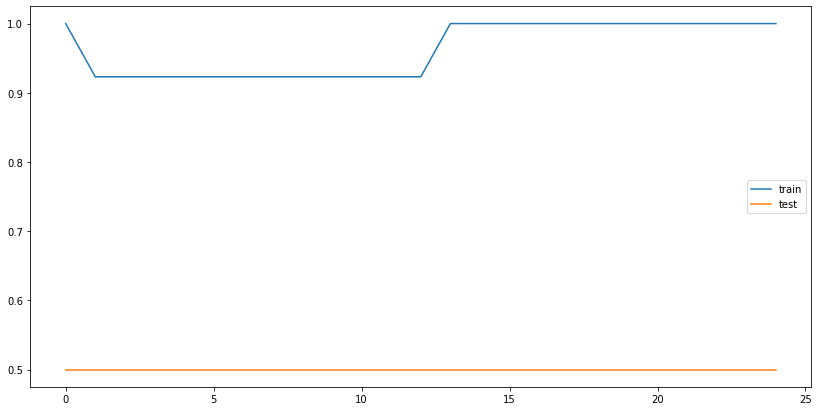

In [43]:
#recall
tab_train = list()
tab_test = list()
for i in range(1,26):
    klasyfikator = sklearn.neighbors.KNeighborsClassifier(n_neighbors=1, leaf_size=i) #tworzenie modelu
    print(klasyfikator)
    klasyfikator.fit(X_cls_ucz, y_cls_ucz) #trenowanie modelu
    
    Y_tr_pred = klasyfikator.predict(X_cls_ucz)
    Y_pred = klasyfikator.predict(X_cls_test) #klasyfikacja zmiennej celu dla zbioru testowego
    
    tab_train.append(sklearn.metrics.recall_score(y_cls_ucz, Y_tr_pred))
    tab_test.append(sklearn.metrics.recall_score(y_cls_test, Y_pred))
 	
#i prezentujemy wyniki
plt.figure(figsize=(14,7))
plt.plot(tab_train, label='train')
plt.plot(tab_test, label='test')
plt.legend()
plt.show()

KNeighborsClassifier(n_neighbors=1)
KNeighborsClassifier(n_neighbors=2)
KNeighborsClassifier(n_neighbors=3)
KNeighborsClassifier(n_neighbors=4)
KNeighborsClassifier()
KNeighborsClassifier(n_neighbors=6)
KNeighborsClassifier(n_neighbors=7)
KNeighborsClassifier(n_neighbors=8)
KNeighborsClassifier(n_neighbors=9)
KNeighborsClassifier(n_neighbors=10)
KNeighborsClassifier(n_neighbors=11)
KNeighborsClassifier(n_neighbors=12)
KNeighborsClassifier(n_neighbors=13)
KNeighborsClassifier(n_neighbors=14)
KNeighborsClassifier(n_neighbors=15)
KNeighborsClassifier(n_neighbors=16)
KNeighborsClassifier(n_neighbors=17)
KNeighborsClassifier(n_neighbors=18)
KNeighborsClassifier(n_neighbors=19)
KNeighborsClassifier(n_neighbors=20)
KNeighborsClassifier(n_neighbors=21)
KNeighborsClassifier(n_neighbors=22)
KNeighborsClassifier(n_neighbors=23)
KNeighborsClassifier(n_neighbors=24)
KNeighborsClassifier(n_neighbors=25)


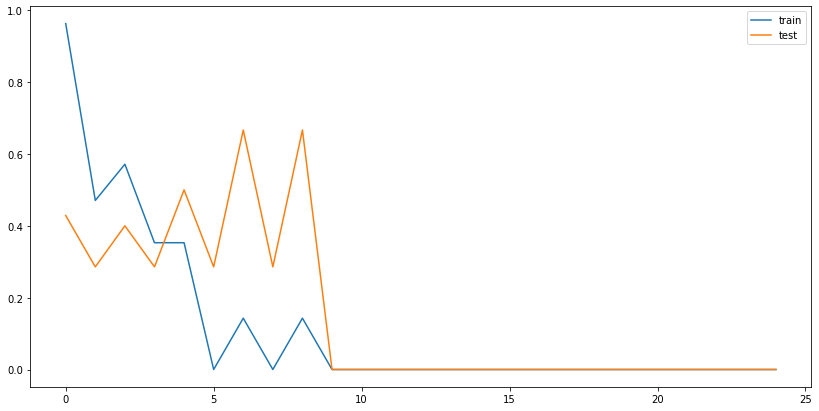

In [44]:
# f1
tab_train = list()
tab_test = list()
for i in range(1,26):
    klasyfikator = sklearn.neighbors.KNeighborsClassifier(n_neighbors=i) #tworzenie modelu
    print(klasyfikator)
    klasyfikator.fit(X_cls_ucz, y_cls_ucz) #trenowanie modelu
    
    Y_tr_pred = klasyfikator.predict(X_cls_ucz)
    Y_pred = klasyfikator.predict(X_cls_test) #klasyfikacja zmiennej celu dla zbioru testowego
    
    tab_train.append(sklearn.metrics.f1_score(y_cls_ucz, Y_tr_pred))
    tab_test.append(sklearn.metrics.f1_score(y_cls_test, Y_pred))
 	
#i prezentujemy wyniki
plt.figure(figsize=(14,7))
plt.plot(tab_train, label='train')
plt.plot(tab_test, label='test')
plt.legend()
plt.show() 

#### Podobnej analizy, ale ze względu na ilość gałęzi drzewa dokonano dla algorytmu drzew decyzyjnych. Zdecydowano, że algorytm spisuje się najlepiej po przycięciu do trzech gałęzi wgłąb. Otrzymuje się wtedy optimum skutecznośći modelu i przeciwdziałaniu zjawiska 'overfittingu'.

DecisionTreeClassifier(max_depth=1)
DecisionTreeClassifier(max_depth=2)
DecisionTreeClassifier(max_depth=3)
DecisionTreeClassifier(max_depth=4)
DecisionTreeClassifier(max_depth=5)
DecisionTreeClassifier(max_depth=6)
DecisionTreeClassifier(max_depth=7)
DecisionTreeClassifier(max_depth=8)
DecisionTreeClassifier(max_depth=9)
DecisionTreeClassifier(max_depth=10)
DecisionTreeClassifier(max_depth=11)
DecisionTreeClassifier(max_depth=12)
DecisionTreeClassifier(max_depth=13)
DecisionTreeClassifier(max_depth=14)
DecisionTreeClassifier(max_depth=15)
DecisionTreeClassifier(max_depth=16)
DecisionTreeClassifier(max_depth=17)
DecisionTreeClassifier(max_depth=18)
DecisionTreeClassifier(max_depth=19)
DecisionTreeClassifier(max_depth=20)
DecisionTreeClassifier(max_depth=21)
DecisionTreeClassifier(max_depth=22)
DecisionTreeClassifier(max_depth=23)
DecisionTreeClassifier(max_depth=24)
DecisionTreeClassifier(max_depth=25)


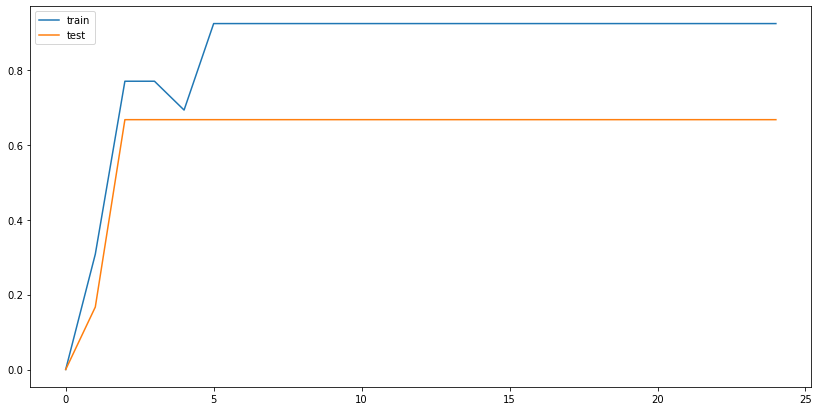

In [45]:
#recall
tab_train = list()
tab_test = list()
for i in range(1,26):
    klasyfikator = sklearn.tree.DecisionTreeClassifier(max_depth=i) #tworzenie modelu
    print(klasyfikator)
    klasyfikator.fit(X_cls_ucz, y_cls_ucz)
    
    Y_tr_pred = klasyfikator.predict(X_cls_ucz)
    Y_pred = klasyfikator.predict(X_cls_test)
    
    tab_train.append(sklearn.metrics.recall_score(y_cls_ucz, Y_tr_pred))
    tab_test.append(sklearn.metrics.recall_score(y_cls_test, Y_pred))
 	

plt.figure(figsize=(14,7))
plt.plot(tab_train, label='train')
plt.plot(tab_test, label='test')
plt.legend()
plt.show()


DecisionTreeClassifier(max_depth=1)
DecisionTreeClassifier(max_depth=2)
DecisionTreeClassifier(max_depth=3)
DecisionTreeClassifier(max_depth=4)
DecisionTreeClassifier(max_depth=5)
DecisionTreeClassifier(max_depth=6)
DecisionTreeClassifier(max_depth=7)
DecisionTreeClassifier(max_depth=8)
DecisionTreeClassifier(max_depth=9)
DecisionTreeClassifier(max_depth=10)
DecisionTreeClassifier(max_depth=11)
DecisionTreeClassifier(max_depth=12)
DecisionTreeClassifier(max_depth=13)
DecisionTreeClassifier(max_depth=14)
DecisionTreeClassifier(max_depth=15)
DecisionTreeClassifier(max_depth=16)
DecisionTreeClassifier(max_depth=17)
DecisionTreeClassifier(max_depth=18)
DecisionTreeClassifier(max_depth=19)
DecisionTreeClassifier(max_depth=20)
DecisionTreeClassifier(max_depth=21)
DecisionTreeClassifier(max_depth=22)
DecisionTreeClassifier(max_depth=23)
DecisionTreeClassifier(max_depth=24)
DecisionTreeClassifier(max_depth=25)


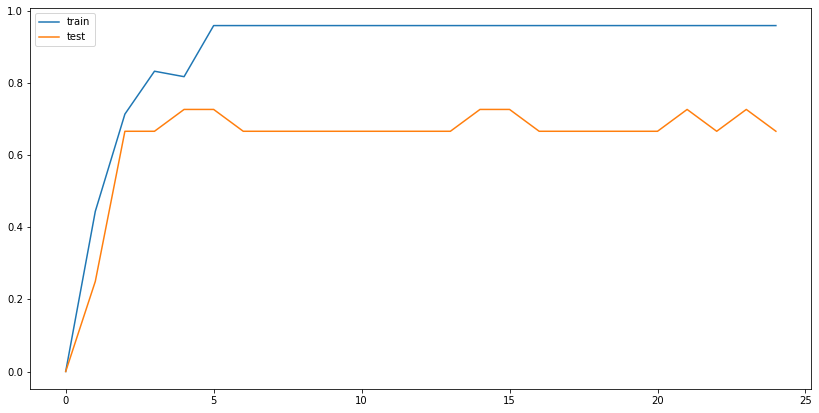

In [46]:
# f1
tab_train = list()
tab_test = list()
for i in range(1,26):
    klasyfikator = sklearn.tree.DecisionTreeClassifier(max_depth=i) #tworzenie modelu
    print(klasyfikator)
    klasyfikator.fit(X_cls_ucz, y_cls_ucz)
    
    Y_tr_pred = klasyfikator.predict(X_cls_ucz)
    Y_pred = klasyfikator.predict(X_cls_test)
    tab_train.append(sklearn.metrics.f1_score(y_cls_ucz, Y_tr_pred))
    tab_test.append(sklearn.metrics.f1_score(y_cls_test, Y_pred))
 	

plt.figure(figsize=(14,7))
plt.plot(tab_train, label='train')
plt.plot(tab_test, label='test')
plt.legend()
plt.show()





#### Przedstawiono wykres drzewa decyzyjnego dla wspomnianego powyżej algorytmu.

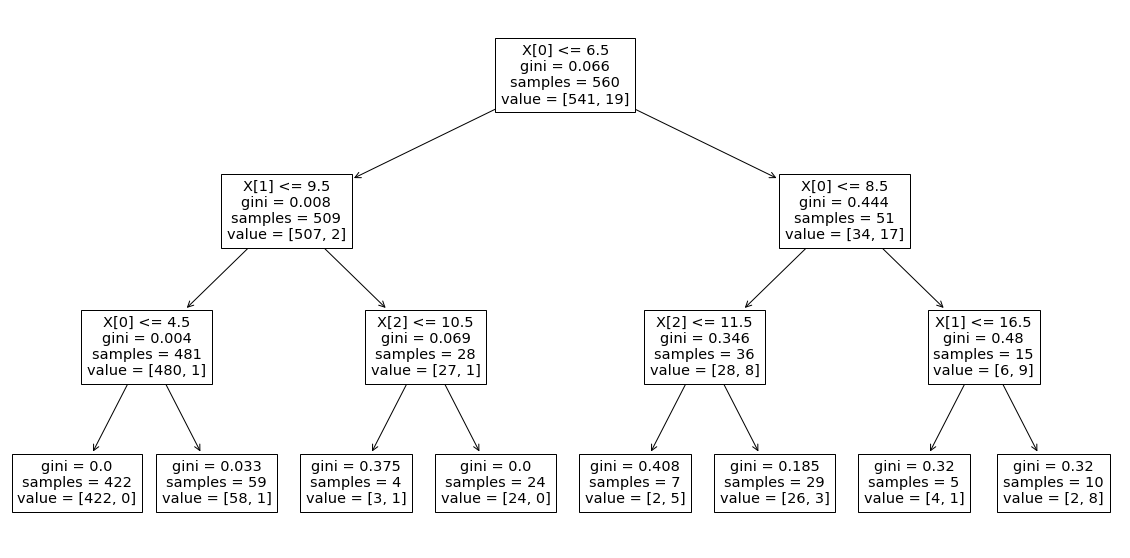

In [50]:
tree_all = sklearn.tree.DecisionTreeClassifier(max_depth=3)
tree_all.fit(X_cls, y_cls)
plt.figure(figsize=(20,10))
sklearn.tree.plot_tree(tree_all)
plt.show()

#### Opisane powyżej elementy ewaluacji modelu zostały ujęte w punkcie 3b) tego raportu.

# 5. Wnioski

#### Stwierdzono, że najlepszym algorytmem klasyfikacji drużyn ze względu na zmienną 'champions' jest algorytm 'dt'. Wykazuje się on najwyższym współczynnikiem recall oraz precision (które są tożsame z założeniami modelu, który miał za zadanie jak najlepiej przewidywać zwycięzców). Szczęśliwie, model 'knn' wyróżnia się również dobrymi wskaźnikami 'r_score' oraz 'accuracy'.  
####  Z poniższego wykresu wynika, że najczęściej zwycięzcą rozgrywek zostaje drużyna która zwyciężyła minimum 9 razy w sezonie, odnotowując w tym czasie bilans bramek minimum +16.5 (liść umieszczony najbardziej po prawej stronie). Jednocześnie, bardzo rzadko zdarza się by zwycięzcą rozgrywek stała się drużyna która wygrała mniej niż 7 meczy (cztery liście po lewej stronie).  